In [ ]:
# Ref: https://www.youtube.com/watch?v=jQxTHfoqArk
#      https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration

In [23]:
!pip install langchain_community langchain_openai langchain_experimental matplotlib langgraph langsmith pandas langchain_core duckduckgo-search

In [4]:
import os, dotenv

dotenv.load_dotenv()

# os.environ["OPENAI_API_KEY"]
# os.environ["TAVILY_API_KEY"]

True

In [6]:
from langchain_core.messages import BaseMessage,HumanMessage,ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable, "
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages")
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [7]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)    # Tavily를 이용해서 웹 상의 정보를 검색하여 취합

In [8]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL() # Python Interpreter

@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."],):
    """Use this to execute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```Stdout: {result}"
    return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")

In [9]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_openai import ChatOpenAI

# This defines the object that is passed between each node in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [25]:
import functools

from langchain_core.messages import AIMessage


# 해당 에이전트의 노드를 만드는데 필요한 헬퍼 함수
def agent_node(state, agent, name):
    result = agent.invoke(state)

    # 에이전트 출력을 전역 상태에 추가될 형식으로 변환한다.
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.model_dump(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # 엄격한 워크플로우를 가지고 있기 때문에 다음에 누구에게 전달하는지 알 수 있다.
        "sender": name,
    }

llm = ChatOpenAI(model="gpt-4o")

In [26]:
# Research 에이전트와 노드
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use, and source code shouldn't be the final answer.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator 에이전트와 노드
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Run the python code to display the chart.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [27]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [28]:
# Either agent can decide to end (FINAL ANSWER)
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # 이전 에이전트가 tool 실행
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # 에이전트 작업이 완료되었음
        return "__end__"
    return "continue"

In [29]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # 각 에이전트는 'sender' 필드를 업데이트한다.
    # 도구를 호출하는 노드는 호출한 원래 에이전트로 돌아간다.
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

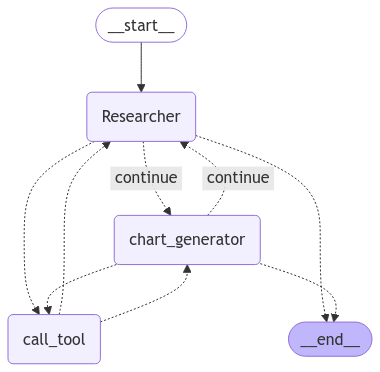

In [30]:
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png(
                output_file_path="./network.png"
            )
        )
    )
except Exception:
    pass

In [31]:
# events = graph.stream(
#     {
#         "messages": [
#             HumanMessage(
#                 content="과거 5년 동안 한국의 GDP를 가져와서 라인 그래프로 그리고, 완료해줘."
#             )
#         ],
#     },
#     # Maximum number of steps to take in the graph
#     {"recursion_limit": 150},
# )
# for s in events:
#     print(s)
#     print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4tFgh3ss3PrGPAzZSjjntsWU', 'function': {'arguments': '{"query":"USA GDP data for the past 3 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 228, 'total_tokens': 255, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-c175c39b-5728-4c20-8bcc-4da957ae5de2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'USA GDP data for the past 3 years'}, 'id': 'call_4tFgh3ss3PrGPAzZSjjntsWU', 'type': 'tool_call'}], usage_metadata={'input_tokens': 228, 'output_tokens

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zq9mB02ps0mgdkmGCzS8ktye', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for the past 3 years\\nyears = [2021, 2022, 2023]\\ngdp_values = [24.78, 26.73, 28.30]  # in trillions\\n\\n# Creating the line graph\\nplt.figure(figsize=(8, 6))\\nplt.plot(years, gdp_values, marker=\'o\')\\n\\n# Adding title and labels\\nplt.title(\\"USA GDP Over the Past 3 Years\\")\\nplt.xlabel(\\"Year\\")\\nplt.ylabel(\\"GDP in Trillions of USD\\")\\nplt.xticks(years)\\n\\n# Display the plot\\nplt.grid(True)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 166, 'prompt_tokens': 1784, 'total_tokens': 1950, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'c

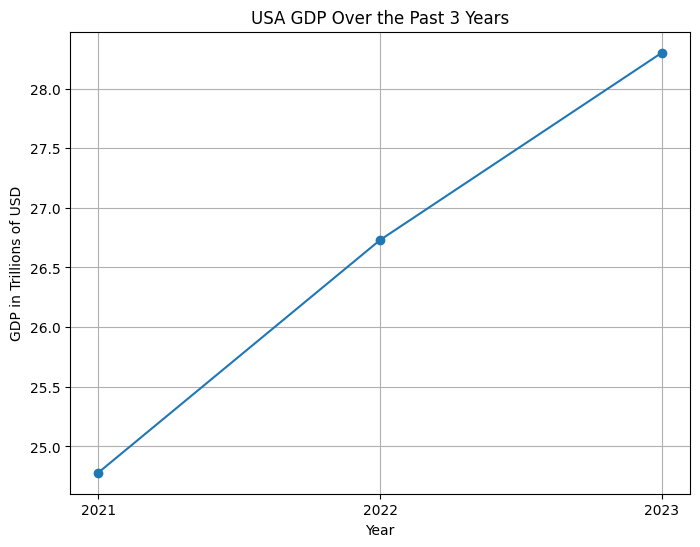

{'call_tool': {'messages': [ToolMessage(content='Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Data for the past 3 years\nyears = [2021, 2022, 2023]\ngdp_values = [24.78, 26.73, 28.30]  # in trillions\n\n# Creating the line graph\nplt.figure(figsize=(8, 6))\nplt.plot(years, gdp_values, marker=\'o\')\n\n# Adding title and labels\nplt.title("USA GDP Over the Past 3 Years")\nplt.xlabel("Year")\nplt.ylabel("GDP in Trillions of USD")\nplt.xticks(years)\n\n# Display the plot\nplt.grid(True)\nplt.show()\n```Stdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.', name='python_repl', tool_call_id='call_zq9mB02ps0mgdkmGCzS8ktye')]}}
----
{'chart_generator': {'messages': [AIMessage(content="FINAL ANSWER: The line graph displaying the USA's GDP over the past three years has been successfully generated, with the values:\n\n- 2021: $24.78 trillion\n- 2022: $26.73 trillion\n- 2023: $28.30 trillion\n\nThe graph illustrates a steady increase in GDP over these

In [32]:
# 그래프가 안나올 때도 有
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the USA's GDP over the past 3 years, then draw a line graph of it. Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")